In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [23]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
             # 'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

In [4]:
import pickle
import itertools
import math
import random
import pandas as pd
import numpy as np
import networkx as nx

from datetime import date

In [48]:
data = pd.read_pickle('../results/us_air_data_binary_removal.pkl').replace([np.inf, -np.inf], np.nan).dropna(how='all')
# data['passenges_centrality'] = data['passenges_centrality'].astype(np.int64)
data = data[data.year>=date(2004,1,1)]
rename_dict = {}
for column in data.columns:
    if '_index' in column:
        column_v = column.replace('_index','',1)
    else:
        column_v =  column
    rename_dict[column]=column_v.replace('_',' ',3).title()
    
rename_again = {'Common Neighbor' : 'CN', 'Salton':'SA' , 'Jaccard':'JA', 'Sorensen':'SO', 'Hub Promoted':'HPI',
       'Hub Depressed':'HDI', 'Leicht Holme Newman':'LHNI', 'Preferential Attachment':'PA',
       'Adamic Adar':'AA', 'Resource Allocation':'RA', 'Local Path':'LP'}
    
data_air = data.rename(columns=rename_dict).rename(columns={'Prederential Attachment':'Preferential Attachment'})

columns=['Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 'Hub Promoted',
       'Hub Depressed', 'Leicht Holme Newman', 'Preferential Attachment',
       'Adamic Adar', 'Resource Allocation', 'Local Path',
        'Year','Edge','Time','Label']

data_air =  data_air[columns]

In [49]:
data = pd.read_pickle('../results/brazil_bus_data_binary_removal.pkl').replace([np.inf, -np.inf], np.nan).dropna(how='all')
data_bus = data.rename(columns=rename_dict).rename(columns={'Prederential Attachment':'Preferential Attachment'})
data_bus =  data_bus[columns]

## split edges into training and testing

In [40]:
def get_edge_slice(data,f_train_e=0.7,seed=30):
    df = data
    edges = list(df.Edge.unique())
    random.seed(seed)
    edge_train = random.sample(edges,int(f_train_e*len(edges)))
    edge_test = [e for e in edges if e not in edge_train]
    df_se = df.loc[df['Edge'].isin(edge_train)].drop(columns = ['Edge','Time'])
    df_de = df.loc[df['Edge'].isin(edge_test)].drop(columns = ['Edge','Time'])
    return(df_se,df_de)

def get_time_slice(data,time_start,time_end,droptime=True):
    if droptime:
        return(data[data.Year >= time_start][data.Year <= time_end].drop(columns = ['Year']))
    else:
        return(data[data.Year >= time_start][data.Year <= time_end])
    
def df_to_XY(df):
    if 'Year' in df.columns: 
        df = df.drop(columns = ['Year'])
        if "Edge" in df.columns:
            df = df.drop(columns = ['Edge'])
    X,y = df.loc[:, df.columns != 'Label'].to_numpy(),\
    df.loc[:, df.columns == 'Label'].to_numpy()
    return(X,y)

In [50]:
bus_se,bus_de = get_edge_slice(data_bus)

In [51]:
air_se,air_de = get_edge_slice(data_air)

## model explain--SHAP values

In [52]:
import shap
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,balanced_accuracy_score

In [81]:
def all_shap_values(df1,df2,clf=XGBClassifier()):
    shap_values_list = []
    year_list = []
    features = df1.columns[0:11]
    for i in df2.Year.unique():
        try:
            X_train,y_train = df_to_XY(df1[ df1.Year == i ].drop(columns = ['Year']))
            X_test,y_test = df_to_XY(df2[ df2.Year == i ].drop(columns = ['Year']))
            ros = RandomUnderSampler(random_state=2020)
            X_resampled, y_resampled = ros.fit_resample(X_train,y_train)
            clf.fit(X_resampled,y_resampled)  
            explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X_test)
#         fig,ax = plt.subplots()
#         plt.title(i)
#         shap.summary_plot(shap_values, pd.DataFrame(X_test,columns=features),alpha=0.7,show=False)
#         plt.xlabel(ax.xaxis.get_label().get_text(),fontsize=30)
#         plt.xticks(fontsize=20)
#         plt.yticks(fontsize=25)
            year_list.append(i)
            shap_values_list.append(shap_values)
        except:
            pass
    return(year_list,shap_values_list)  

In [82]:
bus_year_list,bus_shap_values_list = all_shap_values(bus_se,bus_de)

In [83]:
air_year_list,air_shap_values_list = all_shap_values(air_se,air_de)

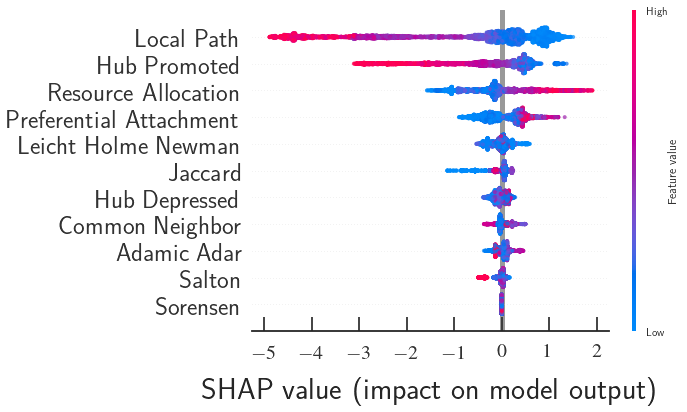

In [84]:
year = date(2005,1,1)
idx = bus_year_list.index(year)
shap_values = bus_shap_values_list[idx]
df= bus_de
features = df.columns[0:11]
X_test = df_to_XY(df[df.Year==year].drop(columns = ['Year']))[0]
fig,ax = plt.subplots(figsize=(xs,ys))
shap.summary_plot(shap_values, pd.DataFrame(X_test,columns=features),alpha=0.7,show=False)
plt.xlabel(ax.xaxis.get_label().get_text(),fontsize=30)
plt.xticks([-5,-4,-3,-2,-1,0,1,2],fontsize=20)
plt.yticks(fontsize=25)
# plt.savefig('../figures/binary_removal_bus_shap.svg',transparent=True)
plt.show()

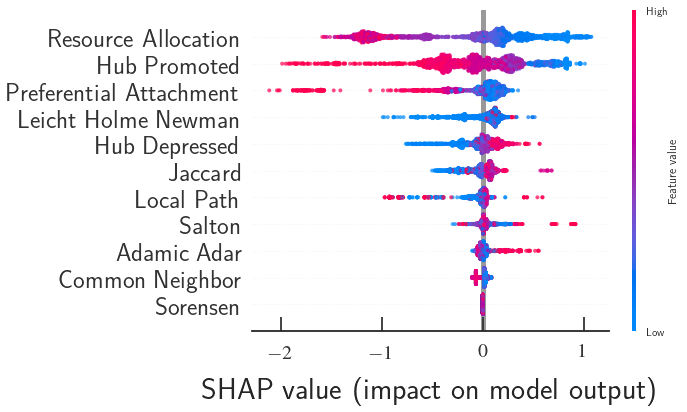

In [75]:
year = date(2004,1,1)
idx = air_year_list.index(year)
shap_values = air_shap_values_list[idx]
df=air_de
features = df.columns[0:11]
X_test = df_to_XY(df[df.Year==year].drop(columns = ['Year']))[0]

fig,ax = plt.subplots(figsize=(xs,ys))
shap.summary_plot(shap_values, pd.DataFrame(X_test,columns=features),alpha=0.7,show=False)
plt.xlabel(ax.xaxis.get_label().get_text(),fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
# plt.savefig('../figures/binary_removal_air_shap.svg',transparent=True)
plt.show()

In [76]:
def get_temporal_order(shap_list):
    importance_array = []
    for shap_values in shap_list: 
        array = -np.abs(shap_values).mean(0)
        order = array.argsort()
        ranks = order.argsort()
        importance_array.append(ranks+1)
    return(np.array(importance_array))

In [77]:
bus_importance = get_temporal_order(bus_shap_values_list)
air_importance = get_temporal_order(air_shap_values_list)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

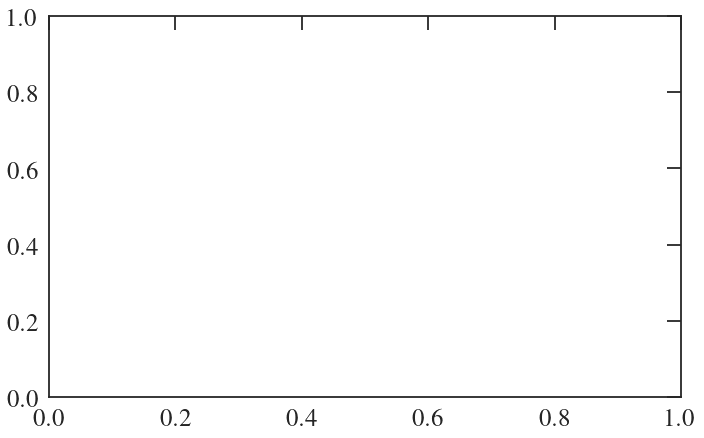

In [78]:
fig,ax = plt.subplots(figsize=(xs,ys))
importance = bus_importance
x= [j for _,j in sorted(zip(importance.T.mean(1),importance.T))]
y=  [j for _,j in sorted(zip(importance.T.mean(1),list(rename_again.keys())))]
ax = sns.heatmap(x,
                 cmap=mpl.cm.get_cmap('Blues_r'),
                 yticklabels=y,
                 xticklabels=False,
                 cbar_kws={'label': 'Feature importance rank',
                           'ticks': [-1,-3,-5,-7,-9,-11] }
                )
plt.ylabel('Features')
plt.xlabel('Time')
# plt.savefig('../figures/binary_removal_bus_shap_all.pdf',transparent=True)
plt.show()

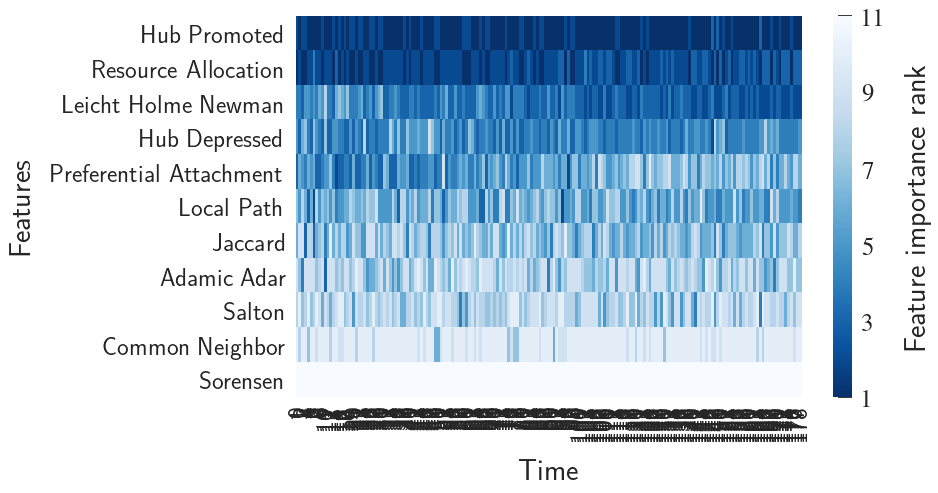

In [80]:
fig,ax = plt.subplots(figsize=(xs,ys))
importance = air_importance
x= [j for _,j in sorted(zip(importance.T.mean(1),importance.T))]
y=  [j for _,j in sorted(zip(importance.T.mean(1),list(rename_again.keys())))]
ax = sns.heatmap(x,
                 cmap=mpl.cm.get_cmap('Blues_r'),
                 yticklabels=y,
                 xticklabels=True,
                 cbar_kws={'label': 'Feature importance rank',
                           'ticks': [1,3,5,7,9,11] }
                )
plt.ylabel('Features')
plt.xlabel('Time')
# plt.savefig('../figures/binary_removal_air_shap_all.pdf',transparent=True)
plt.show()